<a href="https://colab.research.google.com/github/Renan-LS/Renan-LS/blob/main/cred_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case - Modelo preditivo para aprovação de crédito
### Descrição das Features:


 ● idade: A idade do cliente

 ● numero_de_dependentes: O número de pessoas dependentes do cliente.

 ● salario_mensal: Salário mensal do cliente.

 ● numero_emprestimos_imobiliarios: Quantidade de empréstimos imobiliários que o cliente possui em aberto.

 ● util_linhas_inseguras: Quanto que o cliente está usando, relativamente ao limite dele, 
de linhas de crédito que não são seguradas por qualquer bem do tomador e.g: imoveis, carros etc.

 ● vezes_passou_de_30_59_dias: Número de vezes que o cliente atrasou, entre 30 e 59 dias, o pagamento de um empréstimo.
 ● numero_de_vezes_que_passou_60_89_dias: Número de vezes que o cliente atrasou, entre 60 e 89 dias, o pagamento de um empréstimo
 ● numero_vezes_passou_90_dias: Número de vezes que o tomador passou mais de 90 dias em atraso.

 ● razao_debito: Razão entre as dívidas e o patrimônio do tomador. razão débito = Dividas/Patrimônio

 ● numero_linhas_crdto_aberto: Número de empréstimos em aberto pelo cliente.


 ● Saída: 1 - Inadimplente / 0 - Adimplente

### Tratamentos exigidos no Pré-Processamento:
- Coluna idade com registros = 0 (deletados devido a qtde ser relativamente baixa)
- Coluna numero_de_dependentes com valores NaN 
- Coluna salario_mensal com valores NaN
- Classes desbalanceadas
- Tratamento de OUTLIERS


  


In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as sk
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
import pickle


## Pré-Processamento

In [220]:
cred_score_train = pd.read_csv('/content/treino.csv')


In [221]:
pd.options.display.float_format = '{:,.2f}'.format

In [222]:
cred_score_train.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,"110,000.00","110,000.00","110,000.00","110,000.00","110,000.00","88,237.00","110,000.00","110,000.00","110,000.00","110,000.00","107,122.00"
mean,0.07,5.93,52.26,0.42,354.82,"6,637.41",8.45,0.27,1.02,0.24,0.76
std,0.25,252.30,14.77,4.24,"2,074.14","13,383.95",5.14,4.22,1.14,4.20,1.11
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,41.00,0.00,0.18,"3,400.00",5.00,0.00,0.00,0.00,0.00
50%,0.00,0.16,52.00,0.00,0.37,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,0.00,0.56,63.00,0.00,0.87,"8,225.00",11.00,0.00,2.00,0.00,1.00
max,1.00,"50,708.00",109.00,98.00,"329,664.00","3,008,750.00",58.00,98.00,54.00,98.00,20.00


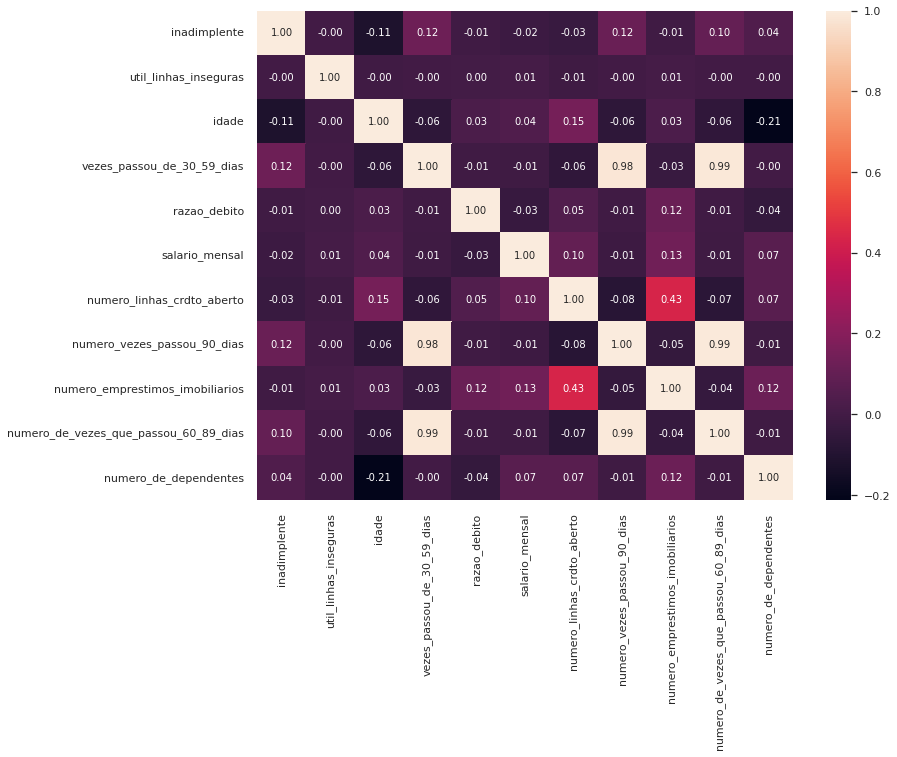

In [223]:
#matriz de correlaçao na qual possibilita a analise simultanea da associação entre as variáveis
#observar correlação quase perfeita entre as vezes que o cliente atrasou
#observar que existe um certo grau de correlação entre N_emp_imob com N_linhas_cred_Abert
corr = cred_score_train.corr()
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=1,annot_kws={'size': 10}, annot=True, fmt='.2f')

(array([0, 1]), array([102669,   7331]))

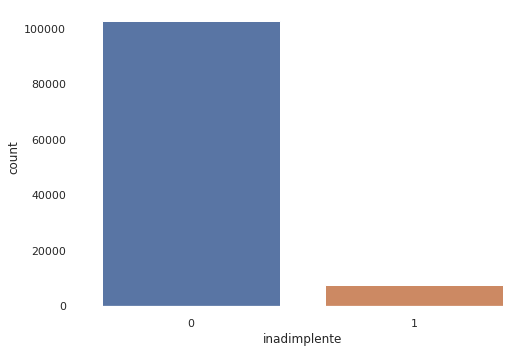

In [224]:
sns.countplot(x = cred_score_train['inadimplente']); #demostrando de forma gráfica a observação anterior
np.unique(cred_score_train['inadimplente'],return_counts=True) #Verificando a quantidade  de registro que existe na variável INADIMPLENTE
# # #nota-se claramente que temos uma classe DESBALACEADA 

In [225]:
graf = px.scatter_matrix(cred_score_train,dimensions=['idade'])
graf.show()
#Verificado que existem amostras com idade = 0

In [226]:
cred_score_train.isnull().sum() #verificado a existencia de valores NaN gerando anomalias

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [227]:
cred_score_train.dropna(subset =['numero_de_dependentes'] , inplace = True)
#Retirando os registros cujo o Nº de dependentes é NaN, devido ao tamanho irrelevante , ao se comparar com o tamanho total da base de dados

mediana = cred_score_train['salario_mensal'].median()
cred_score_train['salario_mensal'].fillna(value=mediana, inplace = True)
#Alterando os valores NaN presente em salario_mensal e substituindo-os pela MEDIANA, devido a quantidade elevada de registros,
#preferi NAO retirá-los

In [228]:
cred_score_train.drop(cred_score_train.loc[cred_score_train['idade'] <= 0].index, inplace=True) #Retirando registros que possuem idade <= 0


In [229]:
#Foram plotados alguns atributos para confirmar a presença de outliers
#A decisão tomada foi de preservar os outliers de modo que eles fazem sentido de acordo com o problema proposto.
#A seguir será feita uma Padronização dos dados de modo a atenuar a forte influencia desses(outliers).
grafico = px.box(cred_score_train,y='numero_emprestimos_imobiliarios')
grafico.show()
grafico = px.box(cred_score_train,y='salario_mensal')
grafico.show()
grafico = px.box(cred_score_train,y='util_linhas_inseguras')
grafico.show()


In [230]:
X_cred = cred_score_train.iloc[:,1:11].values
Y_cred = cred_score_train.iloc[:,0].values
#realizada divisão entre previsores e classes 


In [231]:
X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = train_test_split(X_cred, Y_cred, test_size=0.2, random_state = 0)
#realizando a divisão na razão 80/20 entre os dados de treino e teste.

In [235]:
scaler_cred = StandardScaler()
X_cred_train = scaler_cred.fit_transform(X_cred_train)
X_cred_test = scaler_cred.fit_transform(X_cred_test)
#realizado o reescalonamento dos valores(Padronização)

In [236]:
with open('cred_score_variables.pkl',mode = 'wb') as f:
  pickle.dump([X_cred_train, X_cred_test, Y_cred_train, Y_cred_test],f)
#variáveis de teste e treinamentos salvas em "disco"

## Teste de classificadores

Foram testados 03 classificadores 

In [237]:
#realizada a recuperação das váriáveis de treinamento e teste
with open('cred_score_variables.pkl','rb') as f:
  X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

**RANDOM FOREST**

In [238]:
random_forest_cred = RandomForestClassifier(random_state = 2)
random_forest_cred.fit(X_cred_train,Y_cred_train)

RandomForestClassifier(random_state=2)

In [239]:
previews = random_forest_cred.predict(X_cred_test)

In [240]:
accuracy_score(Y_cred_test,previews)

0.9267211201866978

In [241]:
print(classification_report(Y_cred_test,previews))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     19956
           1       0.43      0.21      0.28      1469

    accuracy                           0.93     21425
   macro avg       0.69      0.59      0.62     21425
weighted avg       0.91      0.93      0.91     21425



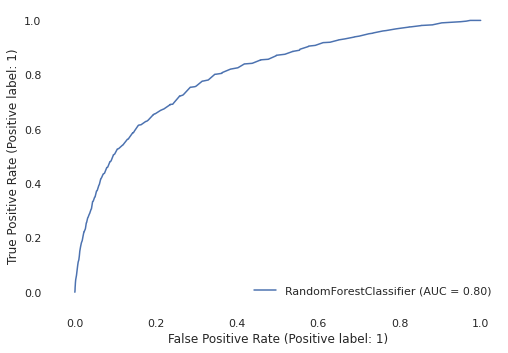

In [242]:
plot_roc_curve(random_forest_cred,X_cred_test,Y_cred_test)

**DECISION TREE**


In [115]:
# with open('cred_score_variables.pkl','rb') as f:
#   X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

In [243]:
tree_cred = DecisionTreeClassifier(random_state = 0)
tree_cred.fit(X_cred_train,Y_cred_train)

DecisionTreeClassifier(random_state=0)

In [244]:
previews = tree_cred.predict(X_cred_test)


In [245]:
accuracy_score(Y_cred_test,previews)

0.7563593932322054

In [246]:
print(classification_report(Y_cred_test,previews))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     19956
           1       0.13      0.45      0.20      1469

    accuracy                           0.76     21425
   macro avg       0.54      0.61      0.53     21425
weighted avg       0.89      0.76      0.81     21425



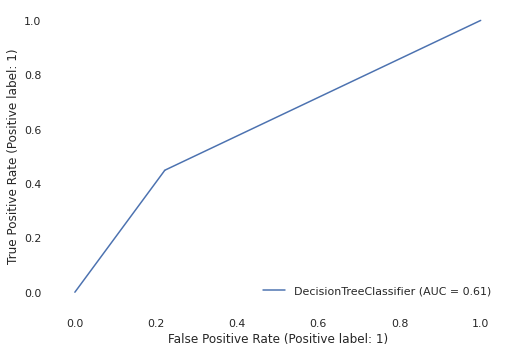

In [247]:
plot_roc_curve(tree_cred,X_cred_test,Y_cred_test)

**LOGISTICAL REGRESSION**

In [120]:
# with open('cred_score_variables.pkl','rb') as f:
#   X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

In [248]:
logistic_cred = LogisticRegression(random_state = 1)
logistic_cred.fit(X_cred_train,Y_cred_train)

LogisticRegression(random_state=1)

In [249]:
previews = logistic_cred.predict(X_cred_test)

In [250]:
accuracy_score(Y_cred_test,previews)

0.9324154025670945

In [251]:
print(classification_report(Y_cred_test,previews))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     19956
           1       0.58      0.05      0.09      1469

    accuracy                           0.93     21425
   macro avg       0.76      0.52      0.53     21425
weighted avg       0.91      0.93      0.91     21425



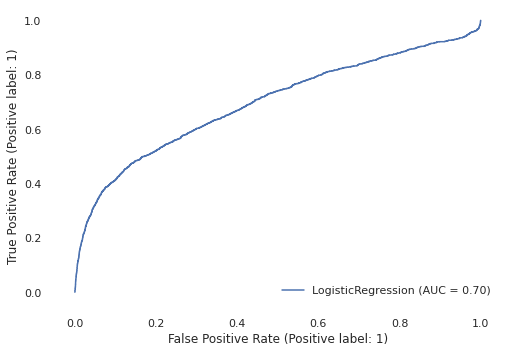

In [252]:
plot_roc_curve(logistic_cred,X_cred_test,Y_cred_test)

**Após a análise das métricas apresentadas, o modelo que será escolhido será a RANDOM FOREST**

## Tunning de modelos e Validação Cruzada

In [6]:
# with open('cred_score_variables.pkl','rb') as f:
#   X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

In [7]:
# X_cred = np.concatenate((X_cred_train,X_cred_test),axis = 0)
# Y_cred = np.concatenate((Y_cred_train,Y_cred_test),axis = 0)
# #Concatenando novamente toda base de dados, já padronizada, de modo a ser utilizada na CV

**Random Forest**

In [ ]:
parameters = {'criterion':['gini','entropy'],
              'n_estimators':[10,40,80,100,150],
              'min_samples_split':[2, 5, 10],
              'min_samples_leaf':[1, 5, 10]}

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters)
grid_search.fit(X_cred,Y_cred)
best_parameters = grid_search.best_params_
best_result = grid_search.best_score_
print(best_parameters)
print(best_result)

{'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}
0.9365670579151789


**Decision Tree**

In [ ]:
# parameters = {'criterion':['gini','entropy'],
#               'splitter':['best','random'],
#               'min_samples_split':[2, 5, 10],
#               'min_samples_leaf':[1, 5, 10]}

In [ ]:
# grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters)
# grid_search.fit(X_cred,Y_cred)
# best_parameters = grid_search.best_params_
# best_result = grid_search.best_score_
# print(best_parameters)
# print(best_result)

{'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'random'}
0.9338318221072693


**Logistic Regression**

In [4]:
# parameters = {'tol':[0.0001, 0.00001, 0.000001],
#               'C':[1.0, 1.5, 2.0],
#               'solver':['lbfgs','sag','saga']}

In [8]:
# grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters)
# grid_search.fit(X_cred,Y_cred)
# best_parameters = grid_search.best_params_
# best_result = grid_search.best_score_
# print(best_parameters)
# print(best_result)

{'C': 2.0, 'solver': 'lbfgs', 'tol': 0.0001}
0.9336357876922727


***Cross Validation***

In [57]:
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# #utilizado o StratifieldKfold devido ao desbalanceamento das classes de saída,pois ele 

# tree = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=10, splitter='random')
# scores = cross_val_score(tree, X_cred, Y_cred, cv=kfold)
# results_tree = scores.mean()

# ##

# random_forest = RandomForestClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=10, n_estimators=150)
# scores = cross_val_score(random_forest, X_cred, Y_cred, cv=kfold)
# results_random_forest = scores.mean()

# ##

# logistic = LogisticRegression(C=2.0, solver = 'lbfgs', tol = 0.0001)
# scores = cross_val_score(logistic, X_cred, Y_cred, cv=kfold)
# results_logistic = scores.mean()

In [ ]:
#results_tree, results_random_forest, results_logistic

## FINALIZANDO O MODELO

UTILIZANDO CV DEFINIR OS GRUPOS DE TREINAMENTO E DE TEST

In [106]:
# random_forest = RandomForestClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=10, n_estimators=150)
# random_forest.fit(X_cred,Y_cred)
# results_random_forest = cross_val_predict(random_forest, X_cred, Y_cred, cv=kfold)
# #scores = cross_val_score(logistic, X_cred, Y_cred, cv=kfold)
# #results_random_forest_mean = scores.mean()

In [ ]:
# #print(results_random_forest_mean)
# print('\n',accuracy_score(Y_cred, results_random_forest))
# print('\n',classification_report(Y_cred, results_random_forest))


UTILIZANDO PROPORCAO 80/20 PARA treino E test, RESPECTIVAMENTE

In [253]:
# with open('cred_score_variables.pkl','rb') as f:
#   X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

#treinando o algoritmo com os melhores parametros obtidos através do GridSearch
random_forest_cred = RandomForestClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=10, n_estimators=150)
random_forest_cred.fit(X_cred_train,Y_cred_train)

previews = random_forest_cred.predict(X_cred_test)
accuracy_score(Y_cred_test,previews)

0.9316219369894982

In [254]:
print(classification_report(Y_cred_test,previews))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     19956
           1       0.50      0.18      0.26      1469

    accuracy                           0.93     21425
   macro avg       0.72      0.58      0.61     21425
weighted avg       0.91      0.93      0.92     21425



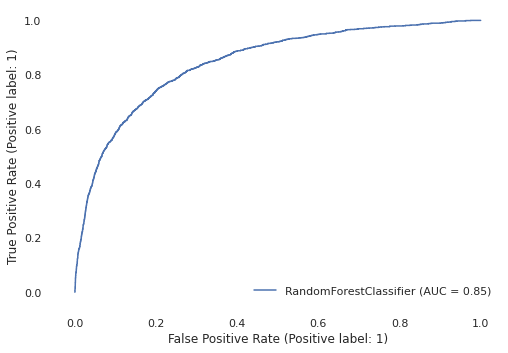

In [255]:
plot_roc_curve(random_forest_cred,X_cred_test,Y_cred_test)

**Testando o modelo com TEST.CSV**


In [256]:
cred_score_teste = pd.read_csv('/content/teste.csv')

In [257]:
cred_score_teste.describe()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,"40,000.00","40,000.00","40,000.00","40,000.00","32,032.00","40,000.00","40,000.00","40,000.00","40,000.00","38,954.00"
mean,6.37,52.40,0.41,348.00,"6,760.60",8.47,0.26,1.01,0.23,0.76
std,242.62,14.78,4.06,"1,934.44","16,836.39",5.16,4.03,1.11,4.02,1.12
min,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.03,41.00,0.00,0.18,"3,400.00",5.00,0.00,0.00,0.00,0.00
50%,0.15,52.00,0.00,0.37,"5,409.50",8.00,0.00,1.00,0.00,0.00
75%,0.55,63.00,0.00,0.87,"8,284.00",11.00,0.00,2.00,0.00,1.00
max,"22,000.00",109.00,98.00,"307,001.00","1,794,060.00",57.00,98.00,25.00,98.00,13.00


In [258]:
cred_score_teste.isnull().sum()

util_linhas_inseguras                       0
idade                                       0
vezes_passou_de_30_59_dias                  0
razao_debito                                0
salario_mensal                           7968
numero_linhas_crdto_aberto                  0
numero_vezes_passou_90_dias                 0
numero_emprestimos_imobiliarios             0
numero_de_vezes_que_passou_60_89_dias       0
numero_de_dependentes                    1046
dtype: int64

In [259]:
#Tratamento dos registro NaN de numero_de_dependentes e salario_mensal, respectivamente
cred_score_teste.dropna(subset =['numero_de_dependentes'] , inplace = True)
mediana = cred_score_teste['salario_mensal'].median()
cred_score_teste['salario_mensal'].fillna(value=mediana, inplace = True)

In [260]:
#alocação dos valores contidos no dataframe Pandas para variável tipo Numpy array
X_cred_teste = cred_score_teste.iloc[:,:].values

In [261]:
#padronizando os valores obtidos da base de dados teste.csv
scaler_cred = StandardScaler()
X_cred_teste = scaler_cred.fit_transform(X_cred_teste)

In [262]:
previsoes = random_forest_cred.predict(X_cred_teste)

In [263]:
cred_score_teste['inadimplente'] = previsoes

In [264]:
cred_score_teste.describe()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
count,"38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00"
mean,6.42,52.22,0.40,328.65,"6,520.52",8.55,0.24,1.02,0.22,0.76,0.01
std,245.27,14.63,3.90,"1,939.45","15,276.08",5.17,3.87,1.12,3.85,1.12,0.08
min,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.03,41.00,0.00,0.17,"3,817.25",5.00,0.00,0.00,0.00,0.00,0.00
50%,0.15,52.00,0.00,0.36,"5,409.50",8.00,0.00,1.00,0.00,0.00,0.00
75%,0.56,62.00,0.00,0.77,"7,500.00",11.00,0.00,2.00,0.00,1.00,0.00
max,"22,000.00",103.00,98.00,"307,001.00","1,794,060.00",57.00,98.00,25.00,98.00,13.00,1.00


(array([0, 1]), array([38718,   236]))

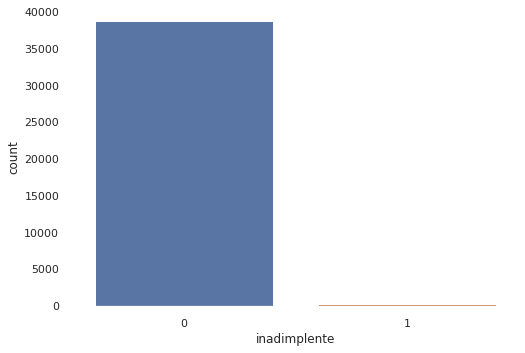

In [265]:
#realizando análise dos dados obtidos após a predição de nosso modelo
sns.countplot(x = cred_score_teste['inadimplente'])
np.unique(cred_score_teste['inadimplente'],return_counts=True)

In [266]:
# salvando o resultado em um novo arquivo CSV
cred_score_teste.to_csv('teste_predict_final.csv', index=False)